In [14]:
import neuro_morpho_toolbox as nmt

import os
import numpy as np
import pandas as pd
import pickle

import sklearn
from sklearn import metrics
import scipy

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import SimpleITK as sitk

sns.set(rc = mpl.rc_params())
%matplotlib inline


In [2]:
mpl.rc_params()

RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.avconv_args': [],
          'animation.avconv_path': 'avconv',
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.html_args': [],
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'black',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
          'axes.f

In [3]:
red = np.array([255,0,0])
green = np.array([0,255,0])
blue = np.array([0,0,255])
orange = np.array([255,105,0])
purple = np.array([160,32,240])
brown = np.array([160,82,45])

## Get GPe cell list

In [4]:
path = "/Users/pengxie/Documents/Research/Thalamus_fullMorpho/Data/swc/Mapped_Feb2021/"
group = "GPe"
distal_thres = 0.8
midline = nmt.annotation.micron_size['z']/2
z_max = nmt.annotation.micron_size['z']
x_max = nmt.annotation.micron_size['x']
y_max = nmt.annotation.micron_size['y']



In [5]:
[ns] = pickle.load(open("neuron_set_1741cells.pickle", 'rb'))

metadata = ns.metadata.copy()
metadata = metadata[metadata['Subclass_or_type'].isin(['CP_SNr', 'CP_GPe'])]
metadata.rename(columns={'Transgenic_line':'creline',
                         'Brain_id':'brain',     
                         'Subclass_or_type':'cluster'
                        }, inplace=True)
metadata['creline'] = [i.split('-')[0] for i in metadata['creline'].tolist()]
metadata['cluster'] = [i.split('_')[1] for i in metadata['cluster'].tolist()]
metadata = metadata[['brain', 'creline', 'cluster']]
metadata = metadata[metadata['creline'].isin(['Tnnt1', 'Vipr2', 'Plxnd1', 'Pvalb'])]
metadata = metadata[metadata['cluster']=='GPe']
nlist = metadata.index.tolist()

metadata.head()


,brain,creline,cluster
17302_00016,17302,Tnnt1,GPe
17302_00017,17302,Tnnt1,GPe
17302_00018,17302,Tnnt1,GPe
17302_00030,17302,Tnnt1,GPe
17302_00033,17302,Tnnt1,GPe


In [6]:
def total_length(swc):
    cswc = swc.copy()
    clist = cswc[cswc['parent'].isin(cswc.index)].index.tolist()
    plist = cswc.loc[clist, 'parent'].tolist()
    res = np.sum(np.square(np.array(cswc.loc[clist, ['x', 'y', 'z']]) - 
                           np.array(cswc.loc[plist, ['x', 'y', 'z']])), axis=1)
    res = np.sum(np.sqrt(res))
    return res

## Soma

In [7]:
soma_df = ns.features['soma_features'].raw_data.copy()
soma_df = soma_df.loc[nlist, ['x', 'y', 'z']]
soma_df.head()

,x,y,z
17302_00016,4940.725,3787.775,2558.650
17302_00017,6709.425,4386.550,2114.175
17302_00018,5019.175,5241.700,2881.175
17302_00030,4083.275,4307.525,2882.150
17302_00033,3988.975,4097.850,3785.250


## Axon

In [8]:
'''
save axon arbors as dataframes,
only consider those within target area
'''

tid = nmt.bs.get_all_child_id(nmt.bs.name_to_id(group))

In [9]:
def get_node_regions(swc, scale=1/25):
    cswc = swc.copy()
    cswc[['x', 'y', 'z']] = cswc[['x', 'y', 'z']] * scale
    cswc[['x', 'y', 'z']] = cswc[['x', 'y', 'z']].round(0).astype(int)
    cswc['region'] = 0
    idlist = cswc[((cswc.x>0) & (cswc.x<nmt.annotation.array.shape[0]) &
                   (cswc.y>0) & (cswc.y<nmt.annotation.array.shape[1]) &
                   (cswc.z>0) & (cswc.z<nmt.annotation.array.shape[2])
                  )].index.tolist()
    cswc.loc[idlist, 'region'] = nmt.annotation.array[cswc.x, cswc.y, cswc.z]
    cswc['region'] = cswc['region'].astype(int)
    return cswc

def get_center(swc, silent=True):
    df = swc.copy()[['x', 'y', 'z']]
    distance = metrics.euclidean_distances(df)
    cid = np.argmin(np.mean(distance, axis=1))
    cid = df.index.tolist()[cid]
    # exclude outliers
    md = metrics.euclidean_distances(np.array(df.loc[cid]).reshape(1, 3), df).reshape(-1,)
    tp = df[md>1000] # define outliers
    outlier_ratio = len(tp) / len(df) * 100
    if not silent:            
        if outlier_ratio>10:
            print("%.2f%% arbor excluded." % (outlier_ratio))
    df.drop(index=tp.index, inplace=True)
    # Re-center
    distance = metrics.euclidean_distances(df)
    cid = np.argmin(np.mean(distance, axis=1))
    cid = df.index.tolist()[cid]
    return cid, outlier_ratio
 

ca = ns.neurons[nlist[0]].swc.copy()
ca['region'] = get_node_regions(ca)['region']
ca = ca[ca.region.isin(tid)]
cc, outlier_ratio = get_center(ca, False)
cc = ca.loc[cc]
cc

type         2.000
x         6173.625
y         4876.575
z         3205.175
r            1.000
parent    3059.000
region    1022.000
Name: 3060, dtype: float64

In [10]:
axon_dict = {}
nlist_selected = []
axon_df = pd.DataFrame(index=nlist, columns=['x', 'y', 'z', 'length'])
for i in nlist:
    cswc = ns.neurons[i].swc.copy()
    cswc = cswc[cswc.type==2]
    cswc['region'] = get_node_regions(cswc)['region']
    cswc = cswc[cswc.region.isin(tid)]
    cswc = cswc[cswc.parent.isin(cswc.index)]
    if len(cswc)>0:
        cc, outlier_ratio = get_center(cswc, True)
        cc = cswc.loc[cc]
    cl = total_length(cswc)/1000
    if cl < 1:
        print('%s:\t%.2fmm' % (i, cl))
    else:
        nlist_selected.append(i)
    axon_dict.update({i:cswc})
    axon_df.loc[i, ['x', 'y', 'z', 'length']] = cc[['x', 'y', 'z']].tolist()+[cl]


17302_00016:	0.75mm
17302_00030:	0.52mm
17302_00033:	0.31mm
17302_00045:	0.99mm
17302_00050:	0.43mm
17302_00056:	0.57mm
17302_00057:	0.52mm
17302_00062:	0.58mm
17302_00063:	0.77mm
17302_00074:	0.56mm
17302_00085:	0.88mm
17302_00091:	0.13mm
17302_00096:	0.26mm
17302_00110:	0.02mm
17302_00124:	0.39mm
17545_00027:	0.59mm
17545_00044:	0.85mm
17545_00052:	0.48mm
17545_00053:	0.33mm
17545_00118:	0.30mm
17545_00120:	0.79mm
17545_00145:	0.86mm
18454_00022:	0.48mm
18455_00041:	0.49mm
18455_00224:	0.96mm
18457_00031:	0.00mm
18457_00035:	0.82mm
18457_00037:	0.18mm
18457_00041:	0.55mm
18457_00141:	0.66mm
18458_00386:	0.66mm
18462_00048:	0.78mm
18462_00050:	0.86mm
18463_00074:	0.47mm
18465_00009:	0.40mm
18465_00281:	0.25mm
18465_00282:	0.00mm
18465_00349:	0.44mm


## distance soma v.s. axon

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



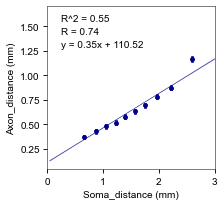

In [60]:
iu = np.triu_indices(len(nlist_selected), k=1)
soma_dist = sklearn.metrics.pairwise_distances(soma_df.loc[nlist_selected, ['x', 'y', 'z']])[iu].reshape(-1,1)
axon_dist = sklearn.metrics.pairwise_distances(axon_df.loc[nlist_selected, ['x', 'y', 'z']])[iu].reshape(-1,1)


df = pd.DataFrame({'Soma_distance (mm)':soma_dist[:,0], 
                   'Axon_distance (mm)':axon_dist[:,0],
                  })/1000

lm = sklearn.linear_model.LinearRegression()
lm.fit(soma_dist, axon_dist)
r2 = lm.score(soma_dist, axon_dist)
c1 = lm.coef_
c2 = lm.intercept_
r = np.corrcoef(soma_dist[:,0], axon_dist[:,0])[0,1]

fig, ax = plt.subplots(1,1, figsize=(3,3))
ax.tick_params(length=4, width=1, color='k')
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.5)

g = sns.regplot("Soma_distance (mm)", "Axon_distance (mm)",
                data=df, 
                x_bins=10,
                order=1, 
                truncate=True,
                ax=ax,
                color='darkblue',
                line_kws={'lw':0.5},
                scatter_kws={'s':15},
                x_jitter=.1)
xlim = ax.get_xlim()
xr = (xlim[1]-xlim[0])
ylim = ax.get_ylim()
yr = (ylim[1]-ylim[0])
txlim = xlim[0] + xr*0.05
ax.set_xlim((0.0,3))
ax.text(txlim, ylim[0] + yr*0.95, "R^2 = %.2f" % (r2), fontdict={'ha':'left', 'va':'top'})
ax.text(txlim, ylim[0] + yr*0.87, "R = %.2f" % (r), fontdict={'ha':'left', 'va':'top'})
ax.text(txlim, ylim[0] + yr*0.79, "y = %.2fx + %.2f" % (c1, c2), fontdict={'ha':'left', 'va':'top'})

fig.savefig("../Figure/soma_axon_regression_GPe_v2.pdf", bbox_inches='tight')

pickle.dump([df], open("Soma_axon_distance_GPe_v2.pickle", 'wb'))

## Axon overlaps

Merging child region GPe into region GPe
Loading time for region GPe : 0.61


(4950.0, 7625.0) (3425.0, 6000.0) (2000.0, 4825.0)
x steps:	35
y steps:	34
z steps:	37
17302_00016 17302_00017
4.3708505440505884e-07


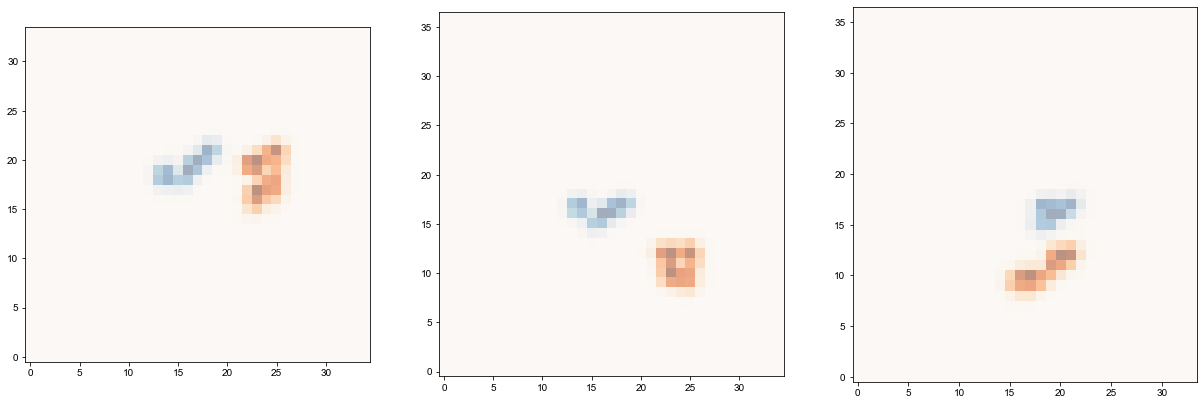

In [15]:
# Get subvolumn
region_id = nmt.bs.name_to_id(group)
tp = nmt.mergeROI([region_id], nmt.annotation.array)
tp[:,:,int(midline/25):] = 0
tp = np.where(tp==region_id)
xlim = (np.max([np.min(tp[0])*25.0 - 500, 0]), 
        np.min([np.max(tp[0])*25.0 + 500, x_max]))
ylim = (np.max([np.min(tp[1])*25.0 - 500, 0]), 
        np.min([np.max(tp[1])*25.0 + 500, y_max]))
zlim = (np.max([np.min(tp[2])*25.0 - 500, 0]), 
        np.min([np.max(tp[2])*25.0 + 500, z_max]))


print(xlim, ylim, zlim)

step_size = 75
x_steps = int((xlim[1]-xlim[0])/step_size)
y_steps = int((ylim[1]-ylim[0])/step_size)
z_steps = int((zlim[1]-zlim[0])/step_size)
print("x steps:\t%d\ny steps:\t%d\nz steps:\t%d" % (x_steps, y_steps, z_steps))

def density_estimation(cur_name, x_steps=20, y_steps=20, plot=True):
    z = axon_dict[cur_name].swc.copy()

    kde = sklearn.neighbors.KernelDensity(bandwidth=50)
    kde.fit(z[['x', 'y']])

    p = np.zeros((x_steps, y_steps))
    xs = np.linspace(xlim[0], xlim[1], num=x_steps)
    ys = np.linspace(ylim[0], ylim[1], num=y_steps)
    for i in range(x_steps):
        for j in range(y_steps):
            p[i,j] = np.exp(kde.score(np.array([xs[i], ys[j]]).reshape(1,2)))
    p = p
    p = p / np.sum(p)
    if plot:
        fig, ax = plt.subplots(1,1, figsize=(7,7))
        ax.imshow(p)
    return p

def density_estimation_3d(cur_name, x_steps=20, y_steps=20, z_steps=20, plot=True):
    z = axon_dict[cur_name].copy()

    kde = sklearn.neighbors.KernelDensity(bandwidth=50)
    kde.fit(z[['x', 'y', 'z']])

    p = np.zeros((x_steps, y_steps, z_steps))
    tp = np.where(p==0)
    tp = np.hstack([tp[0].reshape(-1,1), 
                    tp[1].reshape(-1,1),
                    tp[2].reshape(-1,1)
                   ])*step_size+np.array([xlim[0], ylim[0], zlim[0]]).reshape(1,-1)
    p = np.exp(kde.score_samples(tp)).reshape(x_steps, y_steps, z_steps, order="C")
    p = p / np.sum(p)
    
    if plot:
        fig, ax = plt.subplots(1,1, figsize=(7,7))
        ax.imshow(np.transpose(np.max(p, axis=2)), origin='lower', cmap='Reds', alpha=0.75, aspect='equal')
    return p

def get_overlap(p1, p2):
    res = np.zeros(p1.shape)
    # Calculate the frequency under curve
    lab = np.where(p1>=p2)
    res[lab] = p2[lab]
    lab = np.where(p1<p2)
    res[lab] = p1[lab]
    return np.sum(res)


# 3D version
neuron_1 = nlist[0]
neuron_2 = nlist[1]
p1 = density_estimation_3d(neuron_1, x_steps, y_steps, z_steps, False)
p2 = density_estimation_3d(neuron_2, x_steps, y_steps, z_steps, False)

print(neuron_1, neuron_2)
print(get_overlap(p1, p2))

fig, ax = plt.subplots(1,3, figsize=(21,7))
ax[0].imshow(np.transpose(np.max(p1, axis=2)), origin='lower', cmap='Blues', alpha=0.75, aspect='equal')
ax[0].imshow(np.transpose(np.max(p2, axis=2)), origin='lower', cmap='Oranges', alpha=0.5, aspect='equal')

ax[1].imshow(np.transpose(np.max(p1, axis=1)), origin='lower', cmap='Blues', alpha=0.75, aspect='equal')
ax[1].imshow(np.transpose(np.max(p2, axis=1)), origin='lower', cmap='Oranges', alpha=0.5, aspect='equal')

ax[2].imshow(np.transpose(np.max(p1, axis=0)), origin='lower', cmap='Blues', alpha=0.75, aspect='equal')
ax[2].imshow(np.transpose(np.max(p2, axis=0)), origin='lower', cmap='Oranges', alpha=0.5, aspect='equal')


## Axon overlaps v.s. Soma distance

In [16]:
p_dict = {}
for cur_name in nlist_selected[:]:
    p_dict[cur_name] = density_estimation_3d(cur_name, x_steps, y_steps, z_steps, False)

overlap_df = pd.DataFrame(index=nlist_selected, columns=nlist_selected)
for i in nlist_selected[:]:
    for j in nlist_selected[:]:
        overlap_df.loc[i,j] = get_overlap(p_dict[i], p_dict[j])

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



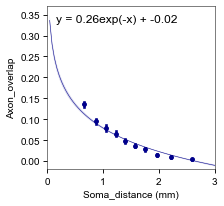

In [61]:
iu = np.triu_indices(len(nlist_selected[:]), 1)
soma_dist = sklearn.metrics.pairwise_distances(soma_df.loc[nlist_selected, ['x', 'y', 'z']])[iu].reshape(-1,1)/1000
axon_over = np.array(overlap_df)[iu].reshape(-1,1)


df = pd.DataFrame({'Soma_distance (mm)':soma_dist[:,0], 
                   'Axon_overlap':axon_over[:,0],
                   'Neuron_1':[nlist_selected[i] for i in iu[0]],
                   'Neuron_2':[nlist_selected[i] for i in iu[1]],
                  }
                 )
df = df.astype({'Soma_distance (mm)':float, 
                   'Axon_overlap':float,
                   'Neuron_1':str,
                   'Neuron_2':str,
                  }
              )


fig, ax = plt.subplots(1,1, figsize=(3,3))
ax.tick_params(length=4, width=1, color='k')
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.5)

g = sns.regplot("Soma_distance (mm)", "Axon_overlap",
                data=df, 
                x_bins=10,
                order=1, 
                logx=True,
                truncate=True,
                ax=ax,
                color='darkblue',
                line_kws={'lw':0.5},
                scatter_kws={'s':15})
ax.set_ylim((-0.02, ax.get_ylim()[1]))
ax.set_xlim((0.0,3))
xlim = ax.get_xlim()
xr = (xlim[1]-xlim[0])
ylim = ax.get_ylim()
yr = (ylim[1]-ylim[0])
txlim = xlim[0] + xr*0.05

lm = sklearn.linear_model.LinearRegression()
ind = df[((df['Soma_distance (mm)']>xlim[0]) & (df['Soma_distance (mm)']<xlim[1]))].index.tolist()
lm.fit(np.exp(-df.loc[ind, ['Soma_distance (mm)']]), 
       df.loc[ind, ['Axon_overlap']])
c1 = lm.coef_
c2 = lm.intercept_
# r2 = lm.score(np.exp(-df.loc[ind, ['Soma_distance (mm)']]), 
#               df.loc[ind, ['Axon_overlap']])  # coefficient of determination
# ax.text(txlim, ylim[0] + yr*0.95, "R^2 = %.2f" % (r2), fontdict={'ha':'left', 'va':'top'})
# ax.text(txlim, ylim[0] + yr*0.87, "R = %.2f" % (r), fontdict={'ha':'left', 'va':'top'})
ax.text(txlim, ylim[0] + yr*0.95, "y = %.2fexp(-x) + %.2f" % (c1, c2), fontdict={'ha':'left', 'va':'top', 'fontsize':12})


fig.savefig("../Figure/soma_axonoverlap_regression_"+group+"_v2.pdf", bbox_inches='tight')

pickle.dump([df], open("Soma_axon_overlap_GPe_v2.pickle", 'wb'))

In [30]:
df_sum_overlap = pd.DataFrame(index=nlist_selected, columns=['Total_overlap'])
for cur_name in nlist_selected:
    df_sum_overlap.loc[cur_name, 'Total_overlap'] = np.sum(df.loc[df.Neuron_1 == cur_name, "Axon_overlap"]) + np.sum(df.loc[df.Neuron_2 == cur_name, "Axon_overlap"])

In [31]:
import igraph


def get_nearest_neighbors(sample_name, df, knn = 3, thres=0.1):
    df = df[df.Axon_overlap>thres]
    df = df[((df.Neuron_1==sample_name) | (df.Neuron_2==sample_name))].sort_values(['Axon_overlap'], ascending=False)
    res = [sample_name]
    for i in range(np.min([knn-1, len(df)])):
        cur_index = df.index[i]
        if df.loc[cur_index, 'Neuron_1'] != sample_name:
            res.append(df.loc[cur_index, 'Neuron_1'])
        else:
            res.append(df.loc[cur_index, 'Neuron_2'])
    return res

def match1d(query, target):
    if not type(query)==list:
        query = query.tolist()
    if not type(target)==list:
        target = target.tolist()
    target = dict(zip(target, range(len(target))))
    if (set(query).issubset(set(target.keys()))):
        result = [target[i] for i in query]
        return (np.array(result))
    else:
        print("Query should be a subset of target!")
        return
    
def get_snn_strength(s1, s2, df, knn = 3, thres=0.1):
    knn1 = get_nearest_neighbors(s1, df, knn, thres)
    knn2 = get_nearest_neighbors(s2, df, knn, thres)
#     print(s1, knn1)
#     print(s2, knn2)
    shared = set(knn1).intersection(set(knn2))
    shared = np.array(list(shared))
    if (len(shared) > 0):  # When i and j have shared knn
        strength = knn - (match1d(shared, knn1) + match1d(shared, knn2) + 2) / 2
        strength = max(strength)
    else:
        strength = 0
    return strength

def SNN(name_list, df, knn=3, thres=0.1):
    res = pd.DataFrame(columns=['Neuron_1', 'Neuron_2', 'strength'])
    ct = 0
    for i in range(len(name_list)-1):
        for j in range(i+1, len(name_list)):
            s1 = name_list[i]
            s2 = name_list[j]
            strength = get_snn_strength(s1, s2, df, knn, thres)
            res.loc[ct] = [s1, s2, strength]
            ct = ct+1
    return res



def get_clusters_community(df, thres=0):
    df = df[df.strength>thres]
    g = igraph.Graph()
    # in order to add edges, we have to add all the vertices first
    # iterate through edges and put all the vertices in a list
    vertex = []
    edge_list = [(df.Neuron_1[i], df.Neuron_2[i]) for i in df.index.tolist()]
    for e in edge_list:
        vertex.extend(e)
    g.add_vertices(list(set(vertex)))  # add a list of unique vertices to the graph
    g.add_edges(edge_list)  # add the edges to the graph.
    g.es['weights'] = df.strength.tolist()
    '''
    Clustering
    '''
#     res = (g.community_fastgreedy(weights='weights').as_clustering().membership)
    res = (g.community_multilevel(weights='weights', return_levels=False).membership) # Louvain
    res = pd.DataFrame(res, index=g.vs['name'], columns=['cluster'])
    return res


In [33]:
edge_thres = 0.1
knn = 10
df_snn = SNN(nlist_selected, df, knn, edge_thres)
df_snn = df_snn[df_snn.strength>0]
axon_cluster = get_clusters_community(df_snn)

soma_df = soma_df.loc[nlist_selected]
axon_df = axon_df.loc[nlist_selected]

soma_df['BrainID'] = ["S_"+i.split("_")[0] for i in soma_df.index.tolist()]
soma_df['CreLine'] = [metadata.loc[i, "creline"] for i in soma_df.index.tolist()]
soma_df['Overlap'] = df_sum_overlap.loc[soma_df.index]

axon_df['BrainID'] = ["S_"+i.split("_")[0] for i in axon_df.index.tolist()]
axon_df['CreLine'] = [metadata.loc[i, "creline"] for i in axon_df.index.tolist()]
axon_df['Overlap'] = df_sum_overlap.loc[axon_df.index]

soma_df['clusters'] = 'Others'
soma_df.loc[axon_cluster.index, 'clusters'] = ['c'+str(i) for i in axon_cluster.cluster.tolist()]
axon_df['clusters'] = 'Others'
axon_df.loc[axon_cluster.index, 'clusters'] = ['c'+str(i) for i in axon_cluster.cluster.tolist()]

soma_df[['x', 'y', 'z']] = soma_df[['x', 'y', 'z']].astype(float)
axon_df[['x', 'y', 'z']] = axon_df[['x', 'y', 'z']].astype(float)

print(soma_df.clusters.value_counts())

c1    48
c2    48
c3    38
c0     7
Name: clusters, dtype: int64


In [53]:
'''
Find representative swc files
'''
# soma_df[((soma_df.clusters=='c1') & (soma_df.registration=='CP'))].sort_values(['y'])
soma_df[((soma_df.clusters=='c1'))].sort_values(['x'])


,x,y,z,BrainID,CreLine,Overlap,clusters
17545_00040,4271.925,4924.650,3425.350,S_17545,Tnnt1,3.75988,c1
17545_00046,4278.750,3968.600,3117.500,S_17545,Tnnt1,5.7126,c1
17545_00143,4505.050,3873.175,2958.500,S_17545,Tnnt1,6.17758,c1
17545_00116,4603.175,4593.975,3004.950,S_17545,Tnnt1,4.96525,c1
18464_00082,4633.450,4931.150,2889.225,S_18464,Vipr2,3.1155,c1
17302_00044,4657.850,3514.350,3111.775,S_17302,Tnnt1,6.08746,c1
18465_00154,4764.250,4884.150,2794.075,S_18465,Vipr2,2.82836,c1
17545_00004,4772.350,4818.075,2798.475,S_17545,Tnnt1,6.17482,c1
17545_00025,4833.925,3653.025,2907.700,S_17545,Tnnt1,9.64684,c1
18454_00004,4850.425,3702.875,2628.675,S_18454,Tnnt1,4.34631,c1


In [54]:
rep_list = ['17545_00028', 
            '17302_00046', 
            '18465_00041', 
            '18457_00142']
soma_df.loc[rep_list]

,x,y,z,BrainID,CreLine,Overlap,clusters
17545_00028,6928.80,4228.625,2205.075,S_17545,Tnnt1,1.86812,c0
17302_00046,5999.60,2829.625,3020.300,S_17302,Tnnt1,6.7697,c1
18465_00041,5518.40,3120.075,3663.850,S_18465,Vipr2,12.0461,c2
18457_00142,4849.45,4831.325,3903.750,S_18457,Vipr2,2.94615,c3


/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:3

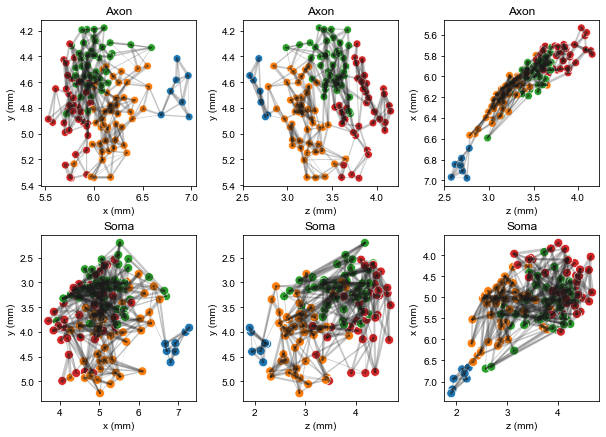

In [46]:
fig, ax = plt.subplots(2,3, figsize=(10,7), gridspec_kw={'hspace':0.3, 'wspace':0.3})
uclusters=sorted(list(set(soma_df.clusters.tolist())))
adf = axon_df.copy()
adf[['x','y','z']] = adf[['x','y','z']]/1000
sdf = soma_df.copy()
sdf[['x','y','z']] = sdf[['x','y','z']]/1000

sthres = np.percentile(df_snn.strength, 80)

axis_pairs = [['x', 'y'], ['z', 'y'], ['z', 'x']]

for i in range(3):
    cx = axis_pairs[i][0]
    cy = axis_pairs[i][1]
    # Axon map
    cax = ax[0,i]
    for cur_name in sdf.index.tolist():
        tp = df_snn[df_snn.Neuron_1==cur_name]
        tp = tp[tp['strength']>sthres]
        for j in tp.index.tolist():
            n = tp.loc[j, ["Neuron_1", "Neuron_2"]].tolist()
            cax.plot(adf.loc[n, cx], 
                     adf.loc[n, cy],
                     lw=df.loc[j, 'Axon_overlap']*7, c='k', alpha=0.25)
    sns.scatterplot(cx, cy, data=adf, 
                    hue='clusters', 
                    hue_order=uclusters,
                    s=60,
                    legend=False,
                    ax=cax)
    cax.invert_yaxis()
    cax.set_title('Axon')
    cax.set_xlabel(cx+' (mm)')
    cax.set_ylabel(cy+' (mm)')

    # Soma map
    cax = ax[1,i]
    for cur_name in sdf.index.tolist():
        tp = df_snn[df_snn.Neuron_1==cur_name]
        tp = tp[tp['strength']>sthres]
        for j in tp.index.tolist():
            n = tp.loc[j, ["Neuron_1", "Neuron_2"]].tolist()
            cax.plot(sdf.loc[n, cx], 
                     sdf.loc[n, cy], 
                     lw=df.loc[j, 'Axon_overlap']*7, c='k', alpha=0.25)
    sns.scatterplot(cx, cy, data=sdf, 
                    hue='clusters', 
                    hue_order=uclusters,
                    s=80,
                    legend=False,
                    ax=cax)
    cax.invert_yaxis()
    cax.set_title('Soma')
    cax.set_xlabel(cx+' (mm)')
    _ = cax.set_ylabel(cy+' (mm)')

fig.savefig("../Figure/axon_network_"+group+"_v2.pdf", bbox_inches='tight')